## Run MD with vanilla/og system and then check that difference in energies between vanilla vs hybrid system are close to 0

In [1]:
from tqdm import tqdm_notebook
import openmmtools
import matplotlib.pyplot as plt
import pickle

from simtk import openmm
from simtk.openmm import unit
import openmmtools
from openmmtools.states import SamplerState, ThermodynamicState, CompoundThermodynamicState
from openmmtools import cache
from openmmtools.constants import kB

from perses.annihilation.lambda_protocol import RESTState, RESTCapableRelativeAlchemicalState, RESTCapableLambdaProtocol
from perses.dispersed import feptasks

import numpy as np

from perses.app.relative_point_mutation_setup import PointMutationExecutor


INFO:rdkit:Enabling RDKit 2021.03.4 jupyter extensions


## Generate htf

In [2]:
from perses.app.relative_point_mutation_setup import PointMutationExecutor
from openeye import oechem

In [3]:
rbd_file = "/home/zhangi/choderalab/perses_benchmark/perses_protein_mutations/input/rbd_protonated.pdb"
ace2_file = "/home/zhangi/choderalab/perses_benchmark/perses_protein_mutations/input/ace2_protonated.pdb"


In [4]:
import simtk.openmm as openmm
import simtk.openmm.app as app
import simtk.unit as unit
import numpy as np

# Set up logger
import logging
_logger = logging.getLogger("setup")
_logger.setLevel(logging.INFO)

class PointMutationExecutor2(PointMutationExecutor):

    def _solvate(self,
               topology,
               positions,
               water_model,
               phase,
               ionic_strength,
               box_dimensions=None):
        """
        Generate a solvated topology, positions, and system for a given input topology and positions.
        For generating the system, the forcefield files provided in the constructor will be used.
        Parameters
        ----------
        topology : app.Topology
            Topology of the system to solvate
        positions : [n, 3] ndarray of Quantity nm
            the positions of the unsolvated system
        forcefield : SystemGenerator.forcefield
            forcefield file of solvent to add
        water_model : str
            solvent model to use for solvation
        phase : str
            if phase == vacuum, then the complex will not be solvated with water; else, it will be solvated with tip3p
        ionic_strength : float * unit.molar
            the total concentration of ions (both positive and negative) to add using Modeller.
            This does not include ions that are added to neutralize the system.
            Note that only monovalent ions are currently supported.
        Returns
        -------
        solvated_topology : app.Topology
            Topology of the system with added waters
        solvated_positions : [n + 3(n_waters), 3] ndarray of Quantity nm
            Solvated positions
        solvated_system : openmm.System
            The parameterized system, containing a barostat if one was specified.
        """
        modeller = app.Modeller(topology, positions)
    
        geompadding = 0.9 * unit.nanometers
        maxSize = max(max((pos[i] for pos in positions))-min((pos[i] for pos in positions)) for i in range(3))
        vectors = openmm.Vec3(1,0,0), openmm.Vec3(1/3,2*np.sqrt(2)/3,0), openmm.Vec3(-1/3,np.sqrt(2)/3,np.sqrt(6)/3)
        boxVectors = [(maxSize+geompadding)*v for v in vectors]
        
        # Now we have to add missing atoms
        if phase != 'vacuum':
            _logger.info(f"solvating at {ionic_strength} using {water_model}")
            modeller.addSolvent(self.system_generator.forcefield, model=water_model, boxVectors=boxVectors, ionicStrength=ionic_strength)
        else:
            pass

        solvated_topology = modeller.getTopology()
        solvated_positions = modeller.getPositions()

        # Canonicalize the solvated positions: turn tuples into np.array
        solvated_positions = unit.quantity.Quantity(value=np.array([list(atom_pos) for atom_pos in solvated_positions.value_in_unit_system(unit.md_unit_system)]), unit=unit.nanometers)
        solvated_system = self.system_generator.create_system(solvated_topology)

        return solvated_topology, solvated_positions, solvated_system


In [5]:
solvent_delivery = PointMutationExecutor2(rbd_file,
                        '1',
                        '501',
                        'TYR',
                        ligand_input=ace2_file,
                        forcefield_files=['amber14/protein.ff14SB.xml', 'amber14/tip3p.xml', '/home/zhangi/choderalab/og_openmmforcefields/openmmforcefields/amber/ffxml/GLYCAM_06j-1.xml'],
                        ionic_strength=0.15*unit.molar,
                        rest_radius=0.2,
                        generate_unmodified_hybrid_topology_factory=False,
                        generate_rest_capable_hybrid_topology_factory=True,
                        conduct_endstate_validation=False,
                       )

DEBUG:openmmforcefields.system_generators:Trying GAFFTemplateGenerator to load gaff-2.11
INFO:setup:solvating at 0.15 M using tip3p
INFO:setup:solvating at 0.15 M using tip3p
INFO:proposal_generator:	Conducting polymer point mutation proposal...
INFO:proposal_generator:local_atom_map: {2605: 2605, 2606: 2606, 2607: 2607, 2608: 2608, 2609: 2609, 2610: 2610, 2611: 2611}
INFO:proposal_generator:the mapped atom names are: [('N', 'N'), ('H', 'H'), ('CA', 'CA'), ('HA', 'HA'), ('C', 'C'), ('O', 'O'), ('CB', 'CB')]
INFO:setup:Changed particle 19's epsilon from 0.0 kJ/mol to 0.0001 kJ/mol
INFO:setup:Changed particle 19's sigma from 1.0 nm to 0.1 nm
INFO:setup:Changed particle 191's epsilon from 0.0 kJ/mol to 0.0001 kJ/mol
INFO:setup:Changed particle 191's sigma from 1.0 nm to 0.1 nm
INFO:setup:Changed particle 256's epsilon from 0.0 kJ/mol to 0.0001 kJ/mol
INFO:setup:Changed particle 256's sigma from 1.0 nm to 0.1 nm
INFO:setup:Changed particle 293's epsilon from 0.0 kJ/mol to 0.0001 kJ/mol
INF

INFO:setup:Changed particle 947's epsilon from 0.0 kJ/mol to 0.0001 kJ/mol
INFO:setup:Changed particle 947's sigma from 1.0 nm to 0.1 nm
INFO:setup:Changed particle 998's epsilon from 0.0 kJ/mol to 0.0001 kJ/mol
INFO:setup:Changed particle 998's sigma from 1.0 nm to 0.1 nm
INFO:setup:Changed particle 1031's epsilon from 0.0 kJ/mol to 0.0001 kJ/mol
INFO:setup:Changed particle 1031's sigma from 1.0 nm to 0.1 nm
INFO:setup:Changed particle 1282's epsilon from 0.0 kJ/mol to 0.0001 kJ/mol
INFO:setup:Changed particle 1282's sigma from 1.0 nm to 0.1 nm
INFO:setup:Changed particle 1373's epsilon from 0.0 kJ/mol to 0.0001 kJ/mol
INFO:setup:Changed particle 1373's sigma from 1.0 nm to 0.1 nm
INFO:setup:Changed particle 1408's epsilon from 0.0 kJ/mol to 0.0001 kJ/mol
INFO:setup:Changed particle 1408's sigma from 1.0 nm to 0.1 nm
INFO:setup:Changed particle 1521's epsilon from 0.0 kJ/mol to 0.0001 kJ/mol
INFO:setup:Changed particle 1521's sigma from 1.0 nm to 0.1 nm
INFO:setup:Changed particle 163

INFO:geometry:log probability choice of torsions and atom order: -21.879230568629588
INFO:geometry:creating platform, integrators, and contexts; setting growth parameter


conducting subsequent work with the following platform: CUDA
conducting subsequent work with the following platform: CUDA


INFO:geometry:setting atoms_with_positions context new positions


conducting subsequent work with the following platform: CUDA


INFO:geometry:There are 14 new atoms
INFO:geometry:	reduced angle potential = 1.7617204787417506.
INFO:geometry:	reduced angle potential = 0.16986825567205344.
INFO:geometry:	reduced angle potential = 0.03340309223359637.
INFO:geometry:	reduced angle potential = 0.06077720120197149.
INFO:geometry:	reduced angle potential = 0.033397108961929614.
INFO:geometry:	reduced angle potential = 3.46666258035115.
INFO:geometry:	reduced angle potential = 0.009116467172486143.
INFO:geometry:	reduced angle potential = 0.0004357212530489901.
INFO:geometry:	reduced angle potential = 1.060686778329862.
INFO:geometry:	reduced angle potential = 0.0005700652260334259.
INFO:geometry:	reduced angle potential = 0.8112533798572975.
INFO:geometry:	reduced angle potential = 0.3714271922874583.
INFO:geometry:	reduced angle potential = 0.49511624788782677.
INFO:geometry:	reduced angle potential = 0.6073773176656405.
INFO:geometry:	beginning construction of no_nonbonded final system...
INFO:geometry:	initial no-no

conducting subsequent work with the following platform: CUDA
conducting subsequent work with the following platform: CUDA


INFO:geometry:total reduced potential before atom placement: 4814.12706797297


conducting subsequent work with the following platform: CUDA
conducting subsequent work with the following platform: CUDA
conducting subsequent work with the following platform: CUDA


INFO:geometry:total reduced energy added from growth system: -26.721934418117012
INFO:geometry:final reduced energy 4902.850518225182
INFO:geometry:sum of energies: 4787.405133554853
INFO:geometry:magnitude of difference in the energies: 115.4453846703294
INFO:geometry:Final logp_proposal: 112.71637129379991
INFO:geometry:logp_reverse: performing reverse proposal
INFO:geometry:logp_reverse: unique new atoms detected; proceeding to _logp_propose...
INFO:geometry:Conducting forward proposal...
INFO:geometry:Computing proposal order with NetworkX...
INFO:geometry:number of atoms to be placed: 7
INFO:geometry:Atom index proposal order is [2614, 2615, 2618, 2613, 2612, 2616, 2617]
INFO:geometry:omitted_bonds: []
INFO:geometry:direction of proposal is reverse; creating atoms_with_positions from old system/topology


added energy components: [('CustomBondForce', 3.1180273054527445), ('CustomAngleForce', 23.361015933560306), ('CustomTorsionForce', 2.8130491153977446), ('CustomBondForce', -56.01402677252781)]


INFO:geometry:creating growth system...
INFO:geometry:	creating bond force...
INFO:geometry:	there are 1719 bonds in reference force.
INFO:geometry:	creating angle force...
INFO:geometry:	there are 5912 angles in reference force.
INFO:geometry:	creating torsion force...
INFO:geometry:	creating extra torsions force...
INFO:geometry:	there are 11202 torsions in reference force.
INFO:geometry:	creating nonbonded force...
INFO:geometry:		grabbing reference nonbonded method, cutoff, switching function, switching distance...
INFO:geometry:		creating nonbonded exception force (i.e. custom bond for 1,4s)...
INFO:geometry:		looping through exceptions calculating growth indices, and adding appropriate interactions to custom bond force.
INFO:geometry:		there are 63551 in the reference Nonbonded force
INFO:geometry:Neglected angle terms : []
INFO:geometry:omitted_growth_terms: {'bonds': [], 'angles': [], 'torsions': [], '1,4s': []}
INFO:geometry:extra torsions: {0: (2617, 2615, 2614, 2611, [1, Qua

conducting subsequent work with the following platform: CUDA


INFO:geometry:setting atoms_with_positions context old positions


conducting subsequent work with the following platform: CUDA


INFO:geometry:There are 7 new atoms
INFO:geometry:	reduced angle potential = 0.556024589180152.
INFO:geometry:	reduced angle potential = 0.16493779391879834.
INFO:geometry:	reduced angle potential = 0.07895606380492864.
INFO:geometry:	reduced angle potential = 0.00026967118536235375.
INFO:geometry:	reduced angle potential = 0.060548176271839116.
INFO:geometry:	reduced angle potential = 0.38088600786860893.
INFO:geometry:	reduced angle potential = 0.0005705976143499401.
INFO:geometry:	beginning construction of no_nonbonded final system...
INFO:geometry:	initial no-nonbonded final system forces ['HarmonicBondForce', 'HarmonicAngleForce', 'PeriodicTorsionForce', 'NonbondedForce', 'MonteCarloBarostat']
INFO:geometry:	final no-nonbonded final system forces dict_keys(['HarmonicBondForce', 'HarmonicAngleForce', 'PeriodicTorsionForce', 'NonbondedForce'])
INFO:geometry:	there are 1719 bond forces in the no-nonbonded final system
INFO:geometry:	there are 5912 angle forces in the no-nonbonded fin

conducting subsequent work with the following platform: CUDA
conducting subsequent work with the following platform: CUDA


INFO:geometry:total reduced potential before atom placement: 4814.12706797297


conducting subsequent work with the following platform: CUDA
conducting subsequent work with the following platform: CUDA
conducting subsequent work with the following platform: CUDA


INFO:geometry:total reduced energy added from growth system: -110.29163441035723
INFO:geometry:final reduced energy 4703.835424677887
INFO:geometry:sum of energies: 4703.835433562613
INFO:geometry:magnitude of difference in the energies: 8.884725161806273e-06
INFO:geometry:Final logp_proposal: 46.99189231457182
INFO:setup:charge diff: 0
INFO:relative:*** Generating RESTCapableHybridTopologyFactory ***


added energy components: [('CustomBondForce', 1.391536201473014), ('CustomAngleForce', 2.0257208453608495), ('CustomTorsionForce', 14.529015552680082), ('CustomBondForce', -128.23790700987118)]


INFO:relative:Old system forces: dict_keys(['HarmonicBondForce', 'HarmonicAngleForce', 'PeriodicTorsionForce', 'NonbondedForce', 'MonteCarloBarostat'])
INFO:relative:New system forces: dict_keys(['HarmonicBondForce', 'HarmonicAngleForce', 'PeriodicTorsionForce', 'NonbondedForce', 'MonteCarloBarostat'])
INFO:relative:No unknown forces.
INFO:relative:r_cutoff is 1.0 nm
INFO:relative:alpha_ewald is 2.7569734238004693
INFO:relative:w_scale is 0.1
INFO:relative:Creating hybrid system
INFO:relative:Adding and mapping old atoms to hybrid system...
INFO:relative:Adding and mapping new atoms to hybrid system...
INFO:relative:Added MonteCarloBarostat.
INFO:relative:getDefaultPeriodicBoxVectors added to hybrid: [Quantity(value=Vec3(x=8.625399999999999, y=0.0, z=0.0), unit=nanometer), Quantity(value=Vec3(x=2.875133333333333, y=8.13210510726193, z=0.0), unit=nanometer), Quantity(value=Vec3(x=-2.875133333333333, y=4.066052553630965, z=7.042609609134006), unit=nanometer)]
INFO:relative:Determined ato

INFO:setup:Changed particle 3251's epsilon from 0.0 kJ/mol to 0.0001 kJ/mol
INFO:setup:Changed particle 3251's sigma from 1.0 nm to 0.1 nm
INFO:setup:Changed particle 3265's epsilon from 0.0 kJ/mol to 0.0001 kJ/mol
INFO:setup:Changed particle 3265's sigma from 1.0 nm to 0.1 nm
INFO:setup:Changed particle 3377's epsilon from 0.0 kJ/mol to 0.0001 kJ/mol
INFO:setup:Changed particle 3377's sigma from 1.0 nm to 0.1 nm
INFO:setup:Changed particle 3613's epsilon from 0.0 kJ/mol to 0.0001 kJ/mol
INFO:setup:Changed particle 3613's sigma from 1.0 nm to 0.1 nm
INFO:setup:Changed particle 3641's epsilon from 0.0 kJ/mol to 0.0001 kJ/mol
INFO:setup:Changed particle 3641's sigma from 1.0 nm to 0.1 nm
INFO:setup:Changed particle 3652's epsilon from 0.0 kJ/mol to 0.0001 kJ/mol
INFO:setup:Changed particle 3652's sigma from 1.0 nm to 0.1 nm
INFO:setup:Changed particle 3692's epsilon from 0.0 kJ/mol to 0.0001 kJ/mol
INFO:setup:Changed particle 3692's sigma from 1.0 nm to 0.1 nm
INFO:setup:Changed particle

INFO:setup:Changed particle 8985's epsilon from 0.0 kJ/mol to 0.0001 kJ/mol
INFO:setup:Changed particle 8985's sigma from 1.0 nm to 0.1 nm
INFO:setup:Changed particle 9045's epsilon from 0.0 kJ/mol to 0.0001 kJ/mol
INFO:setup:Changed particle 9045's sigma from 1.0 nm to 0.1 nm
INFO:setup:Changed particle 9392's epsilon from 0.0 kJ/mol to 0.0001 kJ/mol
INFO:setup:Changed particle 9392's sigma from 1.0 nm to 0.1 nm
INFO:setup:Changed particle 9422's epsilon from 0.0 kJ/mol to 0.0001 kJ/mol
INFO:setup:Changed particle 9422's sigma from 1.0 nm to 0.1 nm
INFO:setup:Changed particle 9456's epsilon from 0.0 kJ/mol to 0.0001 kJ/mol
INFO:setup:Changed particle 9456's sigma from 1.0 nm to 0.1 nm
INFO:setup:Changed particle 9561's epsilon from 0.0 kJ/mol to 0.0001 kJ/mol
INFO:setup:Changed particle 9561's sigma from 1.0 nm to 0.1 nm
INFO:setup:Changed particle 9636's epsilon from 0.0 kJ/mol to 0.0001 kJ/mol
INFO:setup:Changed particle 9636's sigma from 1.0 nm to 0.1 nm
INFO:setup:Changed particle

INFO:setup:Changed particle 591's sigma from 1.0 nm to 0.1 nm
INFO:setup:Changed particle 616's epsilon from 0.0 kJ/mol to 0.0001 kJ/mol
INFO:setup:Changed particle 616's sigma from 1.0 nm to 0.1 nm
INFO:setup:Changed particle 637's epsilon from 0.0 kJ/mol to 0.0001 kJ/mol
INFO:setup:Changed particle 637's sigma from 1.0 nm to 0.1 nm
INFO:setup:Changed particle 668's epsilon from 0.0 kJ/mol to 0.0001 kJ/mol
INFO:setup:Changed particle 668's sigma from 1.0 nm to 0.1 nm
INFO:setup:Changed particle 682's epsilon from 0.0 kJ/mol to 0.0001 kJ/mol
INFO:setup:Changed particle 682's sigma from 1.0 nm to 0.1 nm
INFO:setup:Changed particle 755's epsilon from 0.0 kJ/mol to 0.0001 kJ/mol
INFO:setup:Changed particle 755's sigma from 1.0 nm to 0.1 nm
INFO:setup:Changed particle 789's epsilon from 0.0 kJ/mol to 0.0001 kJ/mol
INFO:setup:Changed particle 789's sigma from 1.0 nm to 0.1 nm
INFO:setup:Changed particle 817's epsilon from 0.0 kJ/mol to 0.0001 kJ/mol
INFO:setup:Changed particle 817's sigma f

INFO:setup:Changed particle 5000's epsilon from 0.0 kJ/mol to 0.0001 kJ/mol
INFO:setup:Changed particle 5000's sigma from 1.0 nm to 0.1 nm
INFO:setup:Changed particle 5377's epsilon from 0.0 kJ/mol to 0.0001 kJ/mol
INFO:setup:Changed particle 5377's sigma from 1.0 nm to 0.1 nm
INFO:setup:Changed particle 5429's epsilon from 0.0 kJ/mol to 0.0001 kJ/mol
INFO:setup:Changed particle 5429's sigma from 1.0 nm to 0.1 nm
INFO:setup:Changed particle 5585's epsilon from 0.0 kJ/mol to 0.0001 kJ/mol
INFO:setup:Changed particle 5585's sigma from 1.0 nm to 0.1 nm
INFO:setup:Changed particle 5644's epsilon from 0.0 kJ/mol to 0.0001 kJ/mol
INFO:setup:Changed particle 5644's sigma from 1.0 nm to 0.1 nm
INFO:setup:Changed particle 5818's epsilon from 0.0 kJ/mol to 0.0001 kJ/mol
INFO:setup:Changed particle 5818's sigma from 1.0 nm to 0.1 nm
INFO:setup:Changed particle 5869's epsilon from 0.0 kJ/mol to 0.0001 kJ/mol
INFO:setup:Changed particle 5869's sigma from 1.0 nm to 0.1 nm
INFO:setup:Changed particle

INFO:setup:Changed particle 11672's epsilon from 0.0 kJ/mol to 0.0001 kJ/mol
INFO:setup:Changed particle 11672's sigma from 1.0 nm to 0.1 nm
INFO:setup:Changed particle 11915's epsilon from 0.0 kJ/mol to 0.0001 kJ/mol
INFO:setup:Changed particle 11915's sigma from 1.0 nm to 0.1 nm
INFO:setup:Changed particle 11982's epsilon from 0.0 kJ/mol to 0.0001 kJ/mol
INFO:setup:Changed particle 11982's sigma from 1.0 nm to 0.1 nm
INFO:setup:Changed particle 12302's epsilon from 0.0 kJ/mol to 0.0001 kJ/mol
INFO:setup:Changed particle 12302's sigma from 1.0 nm to 0.1 nm
INFO:setup:Changed particle 12404's epsilon from 0.0 kJ/mol to 0.0001 kJ/mol
INFO:setup:Changed particle 12404's sigma from 1.0 nm to 0.1 nm
INFO:setup:Changed particle 12559's epsilon from 0.0 kJ/mol to 0.0001 kJ/mol
INFO:setup:Changed particle 12559's sigma from 1.0 nm to 0.1 nm
INFO:setup:Changed particle 12637's epsilon from 0.0 kJ/mol to 0.0001 kJ/mol
INFO:setup:Changed particle 12637's sigma from 1.0 nm to 0.1 nm
INFO:setup:Ch

conducting subsequent work with the following platform: CUDA


INFO:geometry:setting atoms_with_positions context new positions


conducting subsequent work with the following platform: CUDA


INFO:geometry:There are 14 new atoms
INFO:geometry:	reduced angle potential = 0.6484037356922715.
INFO:geometry:	reduced angle potential = 1.6100133404701504.
INFO:geometry:	reduced angle potential = 0.5495826621439324.
INFO:geometry:	reduced angle potential = 0.1330719349968117.
INFO:geometry:	reduced angle potential = 0.39520247285156584.
INFO:geometry:	reduced angle potential = 1.384891563627504.
INFO:geometry:	reduced angle potential = 0.4617294423812987.
INFO:geometry:	reduced angle potential = 1.4296980904553617e-05.
INFO:geometry:	reduced angle potential = 0.0004946707953057395.
INFO:geometry:	reduced angle potential = 0.003579666363186142.
INFO:geometry:	reduced angle potential = 2.9454499629050974.
INFO:geometry:	reduced angle potential = 0.5879156702131446.
INFO:geometry:	reduced angle potential = 0.3363762880769257.
INFO:geometry:	reduced angle potential = 0.46678974658356176.
INFO:geometry:	beginning construction of no_nonbonded final system...
INFO:geometry:	initial no-non

conducting subsequent work with the following platform: CUDA
conducting subsequent work with the following platform: CUDA


INFO:geometry:total reduced potential before atom placement: 23394.109471542095


conducting subsequent work with the following platform: CUDA
conducting subsequent work with the following platform: CUDA
conducting subsequent work with the following platform: CUDA


INFO:geometry:total reduced energy added from growth system: 27.03043437434465
INFO:geometry:final reduced energy 23719.131375631227
INFO:geometry:sum of energies: 23421.13990591644
INFO:geometry:magnitude of difference in the energies: 297.99146971478694
INFO:geometry:Final logp_proposal: 109.92147697007513


added energy components: [('CustomBondForce', 1.6110404085982164), ('CustomAngleForce', 27.720225398607667), ('CustomTorsionForce', 2.1428641246784426), ('CustomBondForce', -4.443695557539668)]


INFO:geometry:logp_reverse: performing reverse proposal
INFO:geometry:logp_reverse: unique new atoms detected; proceeding to _logp_propose...
INFO:geometry:Conducting forward proposal...
INFO:geometry:Computing proposal order with NetworkX...
INFO:geometry:number of atoms to be placed: 7
INFO:geometry:Atom index proposal order is [2614, 2618, 2615, 2613, 2612, 2617, 2616]
INFO:geometry:omitted_bonds: []
INFO:geometry:direction of proposal is reverse; creating atoms_with_positions from old system/topology
INFO:geometry:creating growth system...
INFO:geometry:	creating bond force...
INFO:geometry:	there are 8434 bonds in reference force.
INFO:geometry:	creating angle force...
INFO:geometry:	there are 29337 angles in reference force.
INFO:geometry:	creating torsion force...
INFO:geometry:	creating extra torsions force...
INFO:geometry:	there are 55124 torsions in reference force.
INFO:geometry:	creating nonbonded force...
INFO:geometry:		grabbing reference nonbonded method, cutoff, switch

conducting subsequent work with the following platform: CUDA


INFO:geometry:setting atoms_with_positions context old positions


conducting subsequent work with the following platform: CUDA


INFO:geometry:There are 7 new atoms
INFO:geometry:	reduced angle potential = 0.556024589180152.
INFO:geometry:	reduced angle potential = 0.07895606380492864.
INFO:geometry:	reduced angle potential = 0.16493779391879834.
INFO:geometry:	reduced angle potential = 0.10037577383866193.
INFO:geometry:	reduced angle potential = 0.010150524623603267.
INFO:geometry:	reduced angle potential = 0.0005705976143499401.
INFO:geometry:	reduced angle potential = 0.38088600786860893.
INFO:geometry:	beginning construction of no_nonbonded final system...
INFO:geometry:	initial no-nonbonded final system forces ['HarmonicBondForce', 'HarmonicAngleForce', 'PeriodicTorsionForce', 'NonbondedForce', 'MonteCarloBarostat']
INFO:geometry:	final no-nonbonded final system forces dict_keys(['HarmonicBondForce', 'HarmonicAngleForce', 'PeriodicTorsionForce', 'NonbondedForce'])
INFO:geometry:	there are 8434 bond forces in the no-nonbonded final system
INFO:geometry:	there are 29337 angle forces in the no-nonbonded final

conducting subsequent work with the following platform: CUDA
conducting subsequent work with the following platform: CUDA


INFO:geometry:total reduced potential before atom placement: 23394.109471542095


conducting subsequent work with the following platform: CUDA
conducting subsequent work with the following platform: CUDA
conducting subsequent work with the following platform: CUDA


INFO:geometry:total reduced energy added from growth system: -110.29163441035723
INFO:geometry:final reduced energy 23283.81782824701
INFO:geometry:sum of energies: 23283.817837131737
INFO:geometry:magnitude of difference in the energies: 8.884726980795676e-06
INFO:geometry:Final logp_proposal: 47.21919020245681


added energy components: [('CustomBondForce', 1.391536201473014), ('CustomAngleForce', 2.0257208453608495), ('CustomTorsionForce', 14.529015552680082), ('CustomBondForce', -128.23790700987118)]


INFO:setup:charge diff: 0
INFO:relative:*** Generating RESTCapableHybridTopologyFactory ***
INFO:relative:Old system forces: dict_keys(['HarmonicBondForce', 'HarmonicAngleForce', 'PeriodicTorsionForce', 'NonbondedForce', 'MonteCarloBarostat'])
INFO:relative:New system forces: dict_keys(['HarmonicBondForce', 'HarmonicAngleForce', 'PeriodicTorsionForce', 'NonbondedForce', 'MonteCarloBarostat'])
INFO:relative:No unknown forces.
INFO:relative:r_cutoff is 1.0 nm
INFO:relative:alpha_ewald is 2.7569734238004693
INFO:relative:w_scale is 0.1
INFO:relative:Creating hybrid system
INFO:relative:Adding and mapping old atoms to hybrid system...
INFO:relative:Adding and mapping new atoms to hybrid system...
INFO:relative:Added MonteCarloBarostat.
INFO:relative:getDefaultPeriodicBoxVectors added to hybrid: [Quantity(value=Vec3(x=13.556500000000002, y=0.0, z=0.0), unit=nanometer), Quantity(value=Vec3(x=4.518833333333333, y=12.781190772207244, z=0.0), unit=nanometer), Quantity(value=Vec3(x=-4.5188333333

In [6]:
pickle.dump(solvent_delivery.get_complex_htf(), open("rbd_ace2_complex.pickle", "wb" ))
pickle.dump(solvent_delivery.get_apo_htf(), open("rbd_ace2_apo.pickle", "wb" ))


## Test at lambda = 1

In [2]:
# htf = solvent_delivery.get_apo_htf()
with open("rbd_ace2_apo.pickle", "rb") as f:
    htf = pickle.load(f)
hybrid_system = htf.hybrid_system
hybrid_positions = htf.hybrid_positions
box_vectors = hybrid_system.getDefaultPeriodicBoxVectors()


In [19]:
htf.hybrid_topology.n_atoms

49100

In [3]:
htf.hybrid_system.getForces()

[<openmm.openmm.MonteCarloBarostat; proxy of <Swig Object of type 'OpenMM::MonteCarloBarostat *' at 0x2b478dcd88d0> >,
 <openmm.openmm.CustomBondForce; proxy of <Swig Object of type 'OpenMM::CustomBondForce *' at 0x2b478dcd8c90> >,
 <openmm.openmm.CustomAngleForce; proxy of <Swig Object of type 'OpenMM::CustomAngleForce *' at 0x2b48253550c0> >,
 <openmm.openmm.CustomTorsionForce; proxy of <Swig Object of type 'OpenMM::CustomTorsionForce *' at 0x2b4825355180> >,
 <openmm.openmm.CustomNonbondedForce; proxy of <Swig Object of type 'OpenMM::CustomNonbondedForce *' at 0x2b4825355210> >,
 <openmm.openmm.CustomNonbondedForce; proxy of <Swig Object of type 'OpenMM::CustomNonbondedForce *' at 0x2b48253552a0> >,
 <openmm.openmm.CustomBondForce; proxy of <Swig Object of type 'OpenMM::CustomBondForce *' at 0x2b4825355330> >,
 <openmm.openmm.NonbondedForce; proxy of <Swig Object of type 'OpenMM::NonbondedForce *' at 0x2b48253553c0> >]

In [4]:
T_min = 300 * unit.kelvin
T_max = 600 * unit.kelvin

# Create thermodynamic state
lambda_protocol = RESTCapableLambdaProtocol()
lambda_zero_alchemical_state = RESTCapableRelativeAlchemicalState.from_system(hybrid_system)
thermostate = ThermodynamicState(hybrid_system, temperature=T_min)
compound_thermodynamic_state = CompoundThermodynamicState(thermostate,
                                                          composable_states=[lambda_zero_alchemical_state])

# Set alchemical parameters
beta_0 = 1 / (kB * T_min)
beta_m = 1 / (kB * T_max)
global_lambda = 1
compound_thermodynamic_state.set_alchemical_parameters(global_lambda, beta_0, beta_m, lambda_protocol=lambda_protocol)

print(compound_thermodynamic_state.lambda_rest_bonds)
print(compound_thermodynamic_state.lambda_alchemical_bonds_old)
print(compound_thermodynamic_state.lambda_alchemical_bonds_new)


1.0
0.0
1.0


In [5]:
integrator = openmmtools.integrators.LangevinIntegrator(temperature=300 * unit.kelvin, 
                                    collision_rate=1 / unit.picoseconds, 
                                    timestep=4 * unit.femtoseconds)
context = compound_thermodynamic_state.create_context(integrator)
context.setPositions(hybrid_positions)
context.setPeriodicBoxVectors(*box_vectors)
context.setVelocitiesToTemperature(300 * unit.kelvin)


In [6]:
# Minimize
openmm.LocalEnergyMinimizer.minimize(context)


In [7]:
# Run MD
# hybrid = list()
hybrid_states = list()
for _ in tqdm_notebook(range(int(125000/250))):
    integrator.step(250)
    state = context.getState(getPositions=True, enforcePeriodicBox=False)
    hybrid_states.append(state)
#     pos = context.getState(getPositions=True, enforcePeriodicBox=False).getPositions(asNumpy=True)
#     hybrid.append(pos)


/scratch/lsftmp/4137623.tmpdir/ipykernel_3771/1273711913.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for _ in tqdm_notebook(range(int(125000/250))):


  0%|          | 0/500 [00:00<?, ?it/s]

In [10]:
with open("hybrid_states_rbd_ace2_lambda_1.pickle", "wb") as f:
    pickle.dump(hybrid_states, f)

In [39]:
with open("hybrid_states_rbd_ace2_lambda_1.pickle", "rb") as f:
    hybrid = pickle.load(f)

In [11]:
# Make context for og system
thermodynamic_state = ThermodynamicState(htf._topology_proposal.new_system, temperature=T_min)
integrator_og = openmmtools.integrators.LangevinIntegrator(temperature=300 * unit.kelvin,
                                          collision_rate=1 / unit.picoseconds,
                                          timestep= 4 * unit.femtoseconds)
context_og = thermodynamic_state.create_context(integrator_og)


# Zero the unique old/new valence in the hybrid system
bond_force_index = 1 
angle_force_index = 2 
torsion_force_index = 3 
custom_bond_force = hybrid_system.getForce(bond_force_index)
custom_angle_force = hybrid_system.getForce(angle_force_index)
custom_torsion_force = hybrid_system.getForce(torsion_force_index)
is_old = False
hybrid_to_bond_indices = htf._hybrid_to_new_bond_indices if is_old else htf._hybrid_to_old_bond_indices
hybrid_to_angle_indices = htf._hybrid_to_new_angle_indices if is_old else htf._hybrid_to_old_angle_indices
hybrid_to_torsion_indices = htf._hybrid_to_new_torsion_indices if is_old else htf._hybrid_to_old_torsion_indices
for hybrid_idx, idx in hybrid_to_bond_indices.items():
    p1, p2, hybrid_params = custom_bond_force.getBondParameters(hybrid_idx)
    hybrid_params = list(hybrid_params)
    hybrid_params[-2] *= 0 # zero K_old
    hybrid_params[-1] *= 0 # zero K_new
    custom_bond_force.setBondParameters(hybrid_idx, p1, p2, hybrid_params)
for hybrid_idx, idx in hybrid_to_angle_indices.items():
    p1, p2, p3, hybrid_params = custom_angle_force.getAngleParameters(hybrid_idx)
    hybrid_params = list(hybrid_params)
    hybrid_params[-1] *= 0
    hybrid_params[-2] *= 0
    custom_angle_force.setAngleParameters(hybrid_idx, p1, p2, p3, hybrid_params)
for hybrid_idx, idx in hybrid_to_torsion_indices.items():
    p1, p2, p3, p4, hybrid_params = custom_torsion_force.getTorsionParameters(hybrid_idx)
    hybrid_params = list(hybrid_params)
    hybrid_params[-1] *= 0
    hybrid_params[-2] *= 0
    custom_torsion_force.setTorsionParameters(hybrid_idx, p1, p2, p3, p4, hybrid_params)

# Make context for hybrid system
T_min = 300 * unit.kelvin
T_max = 600 * unit.kelvin

lambda_protocol = RESTCapableLambdaProtocol()
lambda_zero_alchemical_state = RESTCapableRelativeAlchemicalState.from_system(hybrid_system)
thermostate = ThermodynamicState(hybrid_system, temperature=T_min)
compound_thermodynamic_state = CompoundThermodynamicState(thermostate,
                                                          composable_states=[lambda_zero_alchemical_state])

beta_0 = 1 / (kB * T_min)
beta_m = 1 / (kB * T_max)
global_lambda = 1
compound_thermodynamic_state.set_alchemical_parameters(global_lambda, beta_0, beta_m, lambda_protocol=lambda_protocol)

integrator_hybrid = openmmtools.integrators.LangevinIntegrator(temperature=300 * unit.kelvin,
                                          collision_rate=1 / unit.picoseconds,
                                          timestep= 4 * unit.femtoseconds)
context_hybrid = compound_thermodynamic_state.create_context(integrator_hybrid)

# Get energies for each conformation
energies_og = list()
energies_hybrid = list()
for state in tqdm_notebook(hybrid_states):
   
#     context_og.setPositions(htf.new_positions(pos))
    context_og.setPositions(htf.new_positions(state.getPositions(asNumpy=True)))
    context_og.setPeriodicBoxVectors(*state.getPeriodicBoxVectors())
    energy_og = context_og.getState(getEnergy=True).getPotentialEnergy()
    energies_og.append(energy_og.value_in_unit_system(unit.md_unit_system))
    
#     context_hybrid.setPositions(pos)
    context_hybrid.setState(state)
    energy_hybrid = context_hybrid.getState(getEnergy=True).getPotentialEnergy()
    energies_hybrid.append(energy_hybrid.value_in_unit_system(unit.md_unit_system))
    
    print(energy_og, energy_hybrid)

/scratch/lsftmp/4137623.tmpdir/ipykernel_3771/3241187252.py:62: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for state in tqdm_notebook(hybrid_states):


  0%|          | 0/500 [00:00<?, ?it/s]

-713875.8613795792 kJ/mol -713876.0340425913 kJ/mol
-690743.6113795792 kJ/mol -690743.9090425913 kJ/mol
-677424.3613795792 kJ/mol -677424.5340425913 kJ/mol
-670690.6113795792 kJ/mol -670690.7840425913 kJ/mol
-667183.4898307128 kJ/mol -667183.7874940144 kJ/mol
-664249.3367058053 kJ/mol -664249.7593702263 kJ/mol
-663517.5867058053 kJ/mol -663517.6343702263 kJ/mol
-662674.5147158331 kJ/mol -662674.8123799384 kJ/mol
-662365.7647158331 kJ/mol -662366.0623799384 kJ/mol
-661900.9911309965 kJ/mol -661901.1637919687 kJ/mol
-662139.4911309965 kJ/mol -662139.6012919687 kJ/mol
-661876.5831096657 kJ/mol -661876.8182694309 kJ/mol
-662153.5831096657 kJ/mol -662153.7557694309 kJ/mol
-661955.9419131926 kJ/mol -661956.114578962 kJ/mol
-660534.1919131926 kJ/mol -660534.614578962 kJ/mol
-661480.9585227421 kJ/mol -661481.1936892022 kJ/mol
-661452.7679521693 kJ/mol -661452.8156170881 kJ/mol
-661717.5179521693 kJ/mol -661717.6906170881 kJ/mol
-660761.2432965548 kJ/mol -660761.5409612524 kJ/mol
-662111.540510

-663109.7918083691 kJ/mol -663110.0894657079 kJ/mol
-661211.4728713436 kJ/mol -661211.5205272011 kJ/mol
-662474.9812665908 kJ/mol -662475.4664222114 kJ/mol
-662626.6278770235 kJ/mol -662626.8005311786 kJ/mol
-662103.4843560029 kJ/mol -662103.5320102249 kJ/mol
-662757.4843560029 kJ/mol -662757.7820102249 kJ/mol
-663594.591483396 kJ/mol -663594.8266381501 kJ/mol
-663446.2620108784 kJ/mol -663446.4971643888 kJ/mol
-662820.1690772227 kJ/mol -662820.2792280983 kJ/mol
-661769.6690772227 kJ/mol -661769.9667280983 kJ/mol
-662385.961131088 kJ/mol -662386.1337811286 kJ/mol
-661502.3913794304 kJ/mol -661502.626529038 kJ/mol
-663248.8913794304 kJ/mol -663249.064029038 kJ/mol
-663505.888673271 kJ/mol -663506.0613288183 kJ/mol
-662672.9545672718 kJ/mol -662673.2522248842 kJ/mol
-664102.8646462169 kJ/mol -664103.0998008437 kJ/mol
-663863.2599209147 kJ/mol -663863.5575747754 kJ/mol
-664095.3038696148 kJ/mol -664095.6015213592 kJ/mol
-663784.7612662823 kJ/mol -663785.0589203754 kJ/mol
-663126.122412035

-662171.4964508968 kJ/mol -662171.6066139624 kJ/mol
-662732.560464636 kJ/mol -662732.670629535 kJ/mol
-663107.8723347792 kJ/mol -663108.294995341 kJ/mol
-661354.1574488608 kJ/mol -661354.3301109202 kJ/mol
-662715.0051269573 kJ/mol -662715.0527872243 kJ/mol
-663064.2914576302 kJ/mol -663064.5891172984 kJ/mol
-663344.6779302531 kJ/mol -663345.0380902067 kJ/mol
-663357.697462807 kJ/mol -663357.6201204228 kJ/mol
-662319.4175278447 kJ/mol -662319.4651867554 kJ/mol
-662811.3358276067 kJ/mol -662811.570984576 kJ/mol
-662532.8322454155 kJ/mol -662533.004903085 kJ/mol
-662844.7739915159 kJ/mol -662844.9466523564 kJ/mol
-661595.1403735713 kJ/mol -661595.2505351728 kJ/mol
-662401.7115226779 kJ/mol -662401.759182616 kJ/mol
-662536.2963693365 kJ/mol -662536.7815322625 kJ/mol
-662525.2418553103 kJ/mol -662525.5395187275 kJ/mol
-662331.4742670325 kJ/mol -662331.6469298758 kJ/mol
-662339.4742670325 kJ/mol -662339.4594298758 kJ/mol
-662770.7845092146 kJ/mol -662771.0821709819 kJ/mol
-662382.2845092146 

-663337.2686543022 kJ/mol -663337.5663104876 kJ/mol
-663601.2148943585 kJ/mol -663601.2625503361 kJ/mol
-661662.7148943585 kJ/mol -661662.8875503361 kJ/mol
-661919.1098671788 kJ/mol -661919.2825225064 kJ/mol
-662535.116480588 kJ/mol -662535.4141298576 kJ/mol
-662103.8746793708 kJ/mol -662103.9223313151 kJ/mol
-662791.0646704365 kJ/mol -662791.1748199632 kJ/mol
-662519.4818265927 kJ/mol -662519.5294810488 kJ/mol
-663220.2318265927 kJ/mol -663220.3419810488 kJ/mol
-663049.9818265927 kJ/mol -663050.2794810488 kJ/mol
-662966.7667676518 kJ/mol -662966.6894208107 kJ/mol
-662523.2667676518 kJ/mol -662523.5644208107 kJ/mol
-661093.7667676518 kJ/mol -661093.9394208107 kJ/mol
-663212.6317637363 kJ/mol -663212.679417191 kJ/mol
-663479.3882355061 kJ/mol -663479.4358890742 kJ/mol
-663301.6959816031 kJ/mol -663301.6811336306 kJ/mol
-662497.1543216226 kJ/mol -662497.4519751832 kJ/mol
-662685.6453605075 kJ/mol -662685.8180130243 kJ/mol
-662280.8154823105 kJ/mol -662280.8006354467 kJ/mol
-663904.272916

DEBUG:matplotlib.font_manager:findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0.
DEBUG:matplotlib.font_manager:findfont: score(<Font 'cmb10' (cmb10.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'DejaVu Sans Mono' (DejaVuSansMono-Oblique.ttf) oblique normal 400 normal>) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXGeneral' (STIXGeneral.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'cmtt10' (cmtt10.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'DejaVu Sans Display' (DejaVuSansDisplay.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXSizeFourSym' (STIXSizFourSymReg.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'cmss10' (cmss10.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager

The history saving thread hit an unexpected error (OperationalError('disk I/O error')).History will not be written to the database.


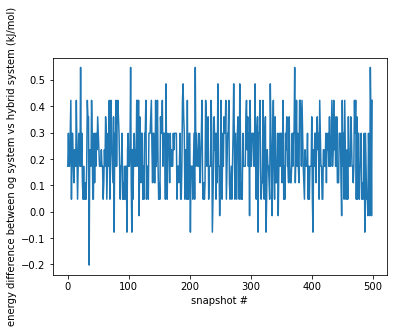

In [12]:
plt.plot(np.array(energies_og) - np.array(energies_hybrid))
plt.ylabel("energy difference between og system vs hybrid system (kJ/mol)")
plt.xlabel("snapshot #")
plt.show()

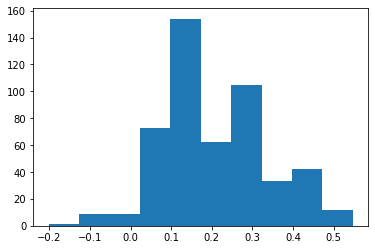

In [13]:
plt.hist(np.array(energies_og) - np.array(energies_hybrid))
plt.show()

In [17]:
np.mean(np.array(energies_og) - np.array(energies_hybrid))

0.2130317678733263

In [18]:
np.std(np.array(energies_og) - np.array(energies_hybrid))

0.13033443387138635

In [15]:
with open("energies_rbd_ace2_hybrid_lambda_1.pickle", "wb") as f:
    pickle.dump(energies_hybrid, f)
with open("energies_rbd_ace2_og_lambda_1.pickle", "wb") as f:
    pickle.dump(energies_og, f)